# Assignment 02 - CIFAR10 Image Classification

In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645__assignment02__team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team__(team number)__FCN.h5 (fully connected model) and team__(team number)__CNN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on (more details in the rubric):

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [33]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

## 1. Load your data

In [34]:
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(X_dev.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## 2. Explore your data 

Showing 10 samples from dev set

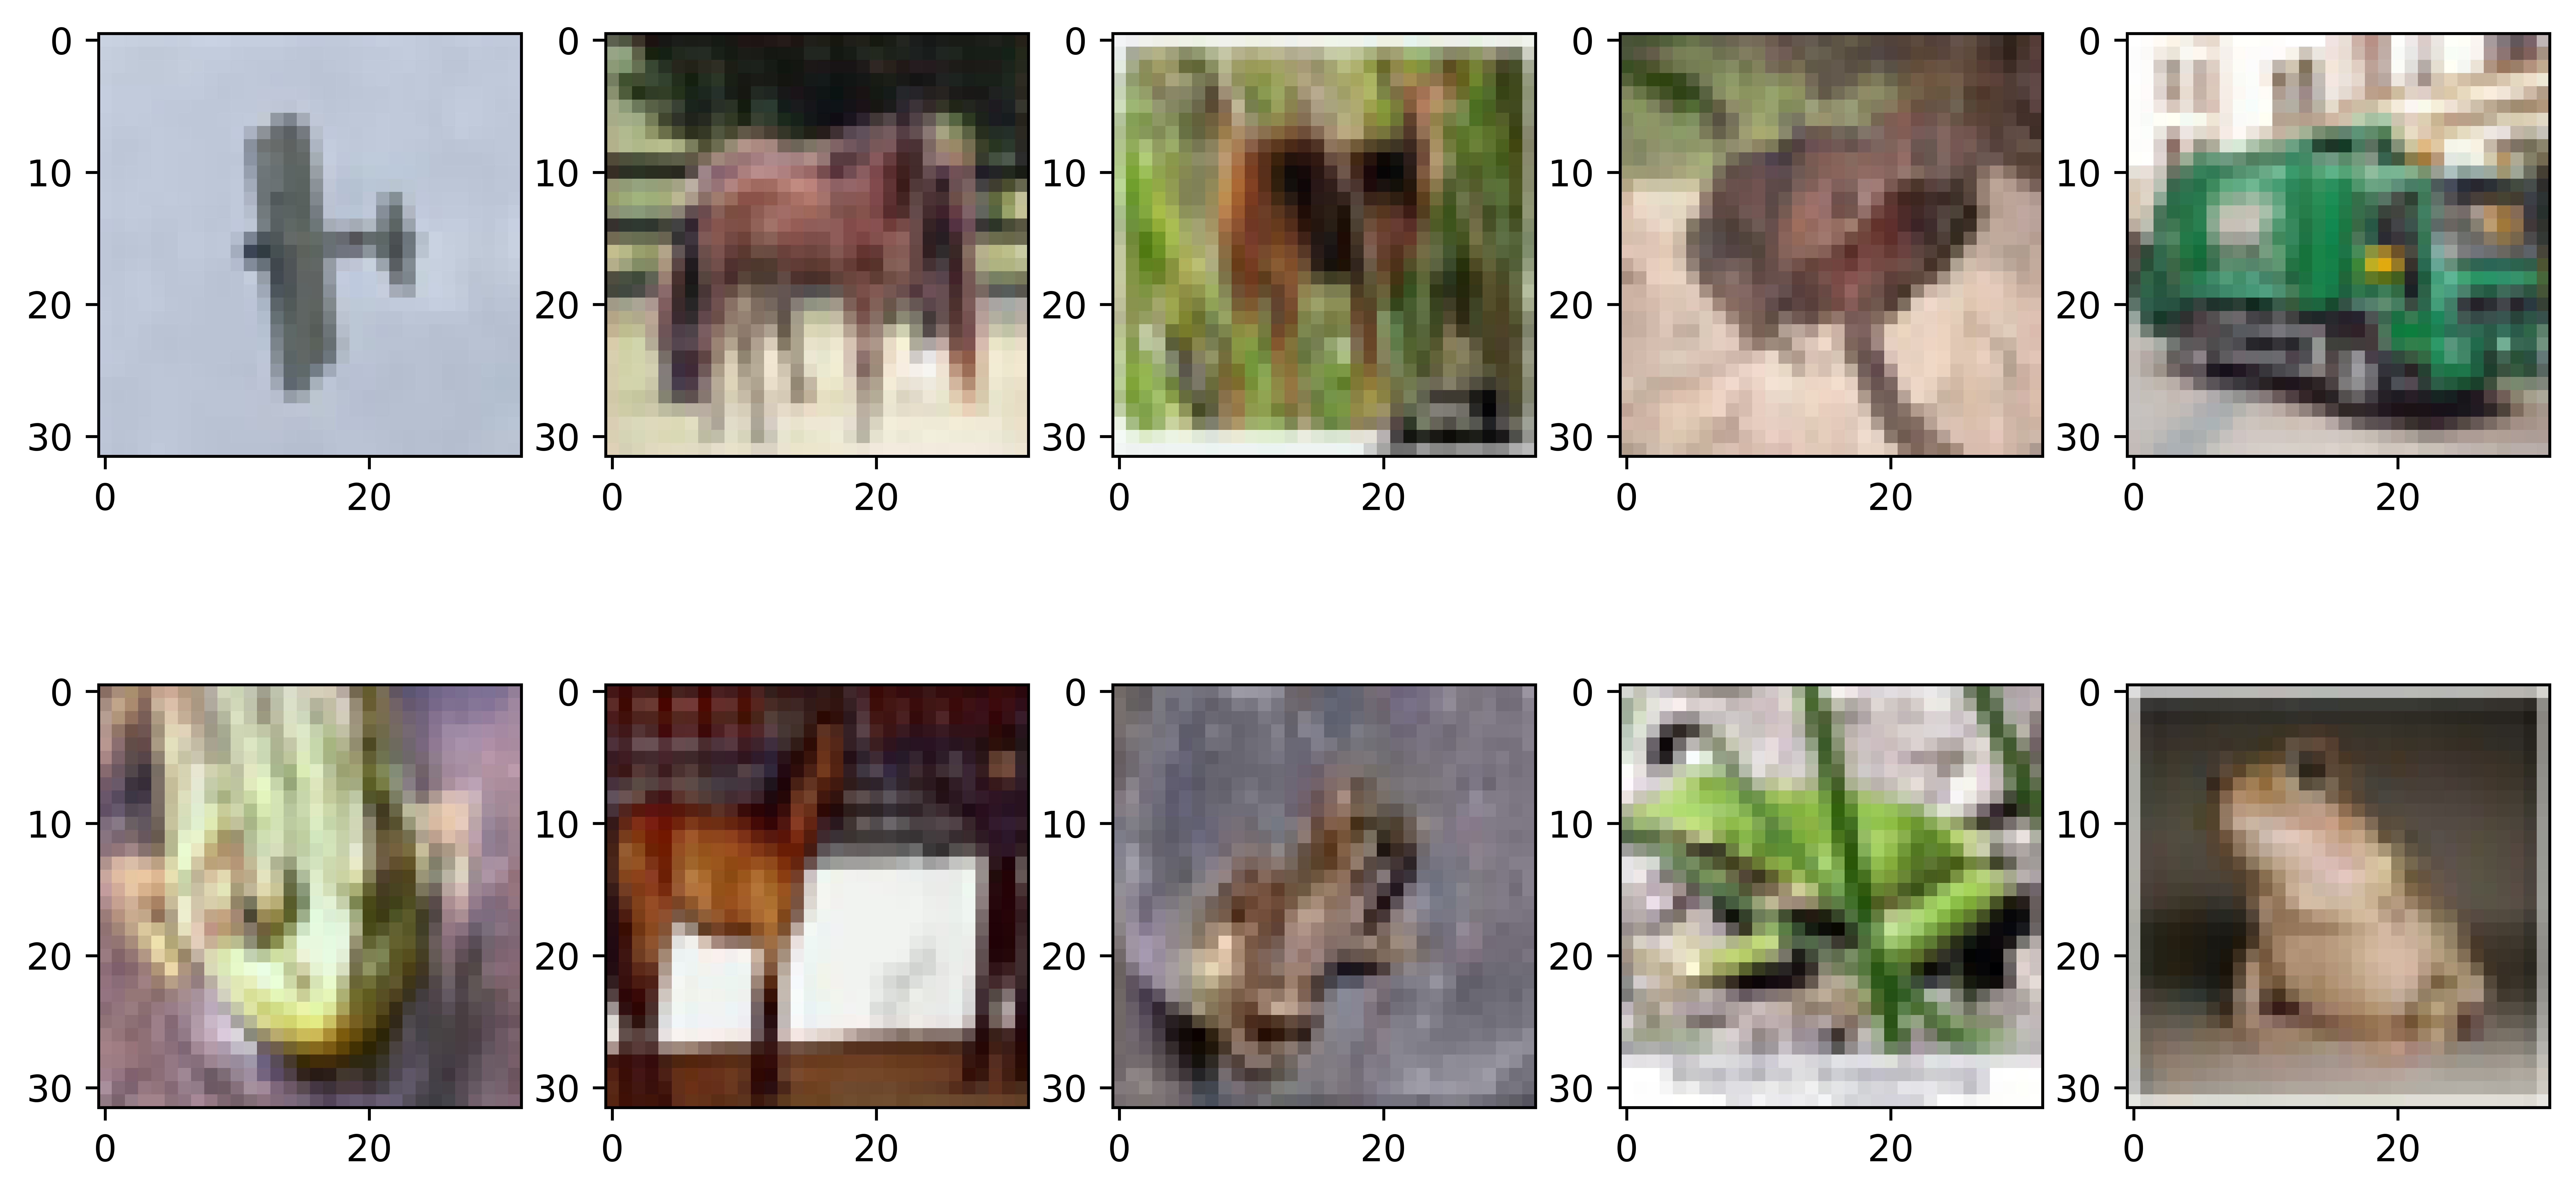

In [52]:
plt.figure(figsize=(12, 6), dpi=1000)
indexes = np.arange(len(X_dev))
np.random.shuffle(indexes)
for idx in range(10):
  plt.subplot(2, 5, idx + 1)
  plt.imshow(X_dev[indexes[idx]])
plt.show()

#Splitting dev set into train/val set

In [53]:
splitter = int(len(X_dev) * .7) #= splitting point of train/val set

X_train = X_dev[indexes[:splitter]]
Y_train = Y_dev[indexes[:splitter]]

X_val = X_dev[indexes[splitter:]]
Y_val = Y_dev[indexes[splitter:]]

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)

X_train: (35000, 32, 32, 3)
X_val: (15000, 32, 32, 3)


## 3. Represent your labels using one hot encoding

In [54]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)

print("Y_train",  Y_train[:3])
print("Y_train_oh:",  Y_train_oh[:3])
print("Y_val",  Y_val[:3])
print("Y_val_oh:",  Y_val_oh[:3])


Y_train [[0]
 [7]
 [4]]
Y_train_oh: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Y_val [[4]
 [9]
 [9]]
Y_val_oh: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 4. Data scaling and Data augmentation

In [1]:
# Experiment with different data scaling methods

scaling_mode = 1 #= 0: disabled, 1: min-max normalization, 2: standardization

if scaling_mode == 1: 
  x_train_min = X_train.min(axis=1, keepdims=True)
  x_train_max = X_train.max(axis=1, keepdims=True)
  X_train = ( X_train - x_train_min ) / (x_train_max - x_train_min)

  x_val_min = X_val.min(axis=1, keepdims=True)
  x_val_max = X_val.max(axis=1, keepdims=True)
  X_val = ( X_val - x_val_min ) / (x_val_max - x_val_min)

elif scaling_mode == 2:
  x_train_mean = X_train.mean(axis=1, keepdims=True)
  x_train_std = X_train.std(axis=1, keepdims=True)
  X_train = ( X_train - x_train_mean ) / x_train_std

  x_val_mean = X_val.mean(axis=1, keepdims=True)
  x_val_std = X_val.std(axis=1, keepdims=True)
  X_val = ( X_val - x_val_mean ) / x_val_std

# Create your data augmentation object to improve training
# set your batch size

NameError: ignored

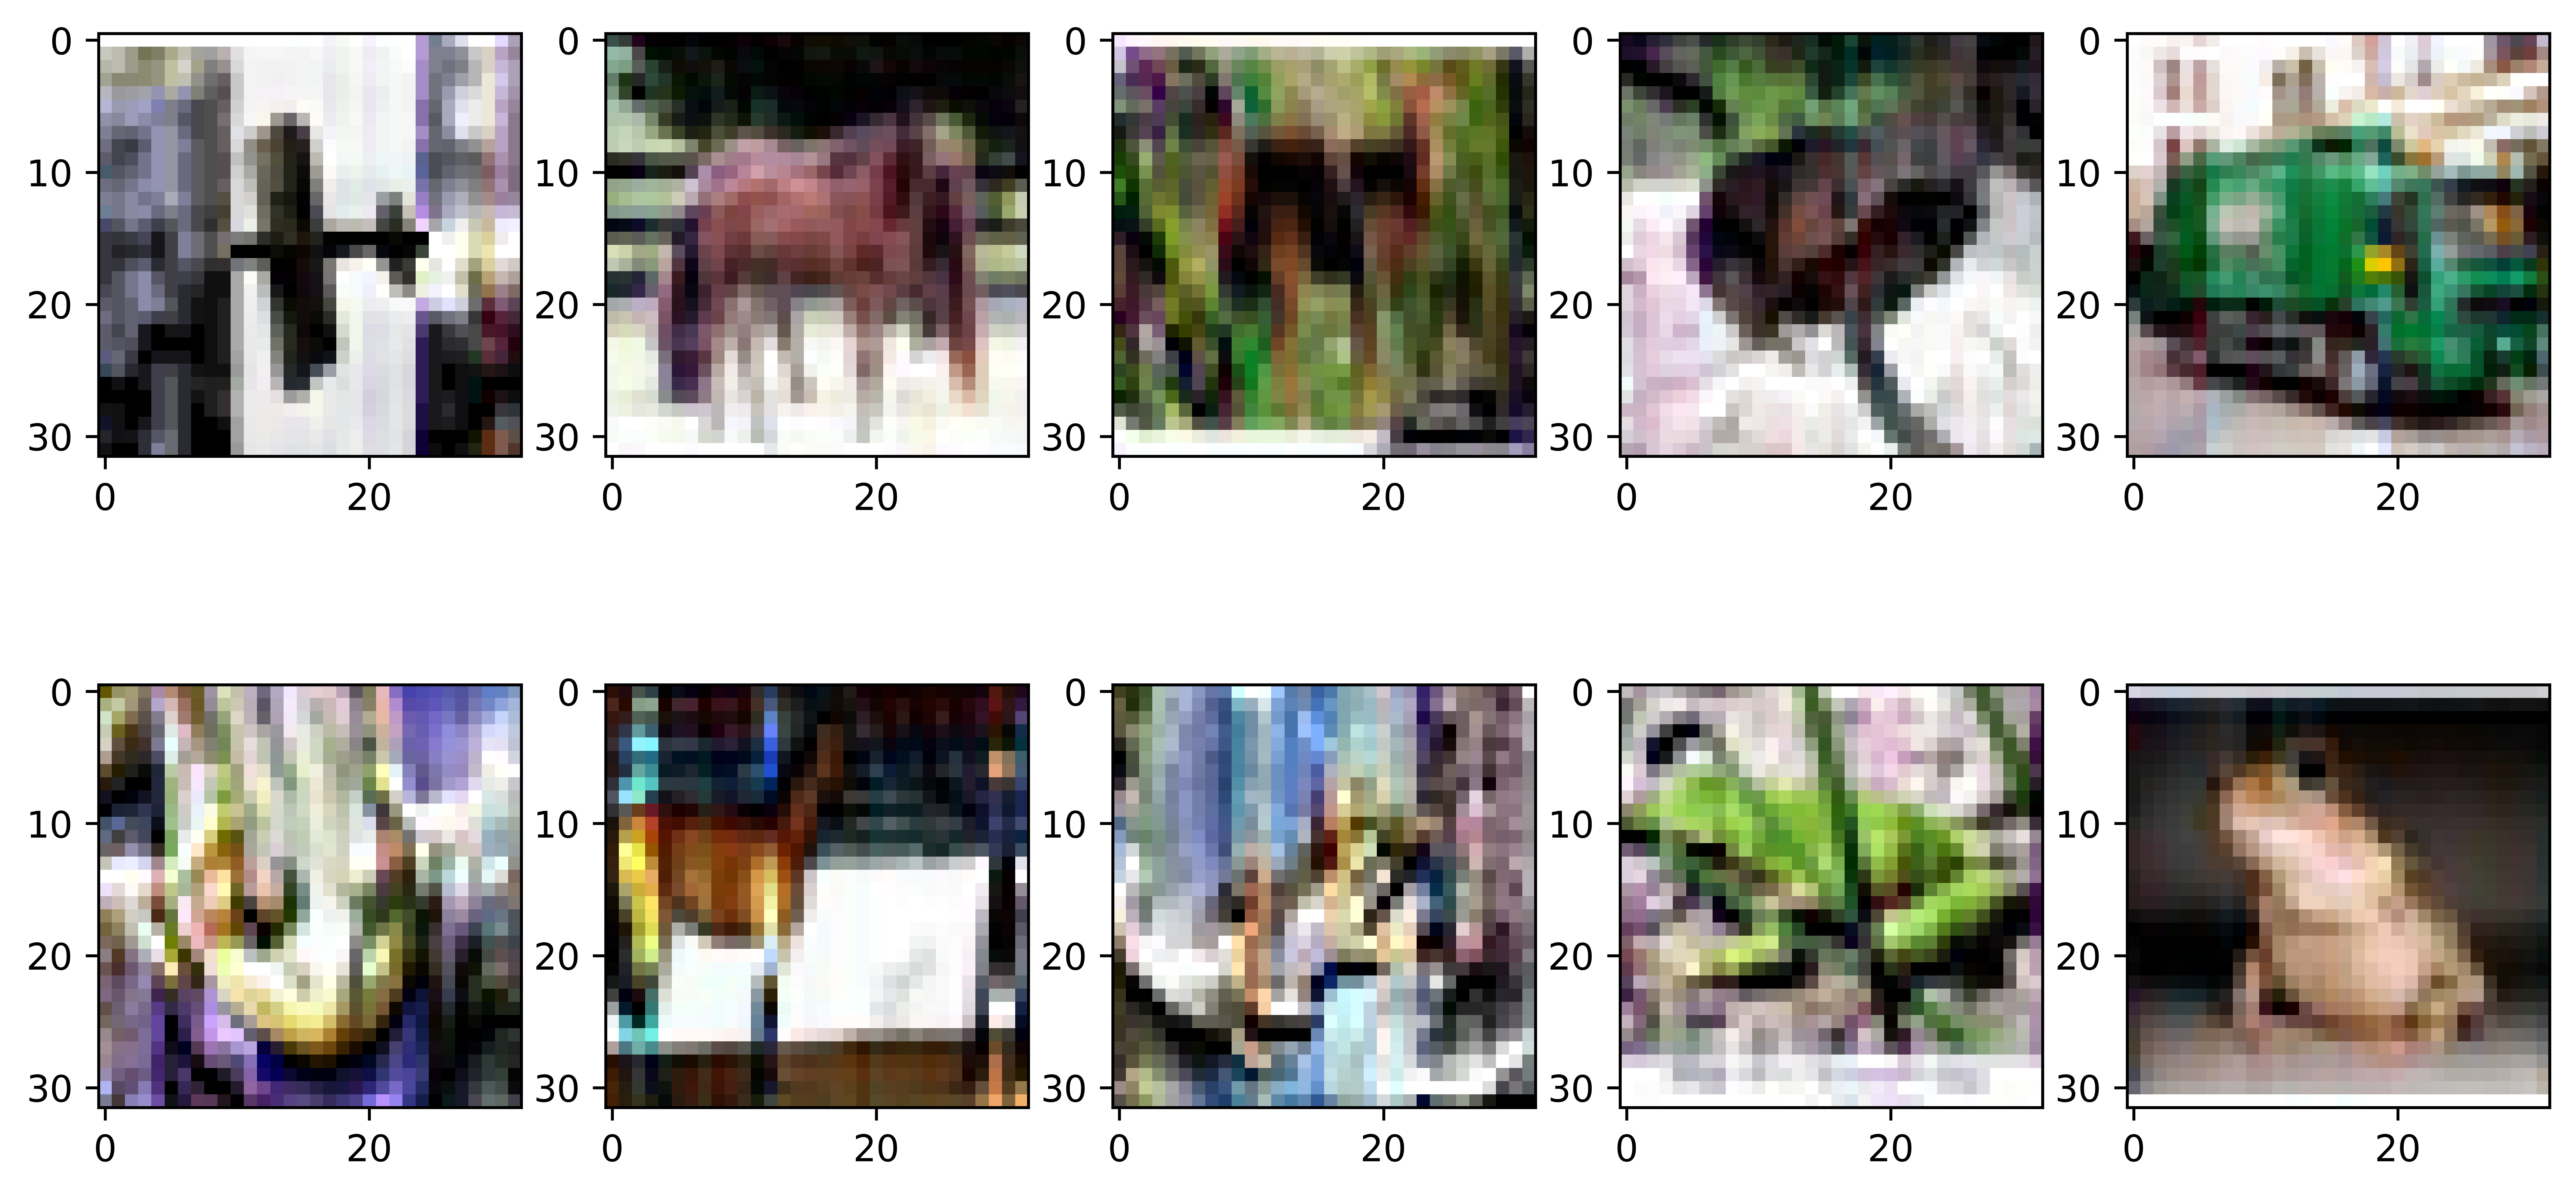

In [59]:
plt.figure(figsize=(12, 6), dpi=1000)
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(X_train[i])

plt.show()

## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_fully_connected():
    
    return

## 6. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_fcn = "team_(team number)_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

## 7. Train your model

In [ ]:
# train your model - decide for how many epochs

## 8. Test your model

In [ ]:
model.load_weights(model_name_fcn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_cnn():
    
    return

## 6. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_cnn = "team_(team number)_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

## 7. Train your model

In [ ]:
# train your model - decide for how many epochs

## 8. Test your model

In [ ]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Arya Stark** helped design the model and write the code for fully connected model (**score 3**)
- **Luke Skywalker** helped design helped to implement the data augmentation module (**score 3**)
- ...